In [94]:
import numpy as np
if not hasattr(np, 'longfloat'):
    np.longfloat = np.float64
import serpentTools as st
from pathlib import Path
from numpy.linalg import norm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import openmc
import openmc.deplete

# Post-Processing Functions

In [95]:
def calculate_reactivity(keff, keff_err, confidence_factor=3):
    """Calculate reactivity and uncertainty from keff values."""
    rho = (1 - 1/keff) * 1e5  # Convert to pcm
    rho_err = confidence_factor * np.sqrt((1/keff**2)**2 * keff_err**2) * 1e5
    return rho, rho_err

def load_openmc_results(filepath):
    """Load OpenMC depletion results and calculate reactivity."""
    results = openmc.deplete.Results(filename=filepath)
    time, keff = results.get_keff(time_units='d')
    
    k_values = keff[:, 0]
    k_errors = keff[:, 1]
    rho, rho_err = calculate_reactivity(k_values, k_errors)
    
    # Convert time to burnup (assuming specific conversion factor)
    burnup = time * 0.600 / 6.56
    
    return burnup, rho, rho_err

def load_serpent_results(res_path, dep_path):
    """Load Serpent results and calculate reactivity."""
    # Load results and depletion data
    dep = st.read(res_path)
    burnup = st.read(dep_path).burnup
    
    # Extract keff values
    k_values = dep['impKeff'][:, 0]
    k_errors = dep['impKeff'][:, 1]
    
    # Calculate reactivity
    rho, rho_err = calculate_reactivity(k_values, k_errors)
    
    return burnup, rho, rho_err

def adjust_for_hydrogen_loss(rho, burnup, bias_correction=684.2, h_loss_rate=161.91174391612):
    """Apply bias correction and hydrogen loss adjustment."""
    rho_corrected = rho + bias_correction
    hydrogen_loss = h_loss_rate * burnup
    rho_adjusted = rho_corrected - hydrogen_loss
    return rho_adjusted

def calculate_heat_transfer_coefficient(temperature_kelvin):
    """
    Calculates the overall fuel to coolant heat transfer coefficient (kWt/K) 
    as a function of temperature in Kelvin.
    
    The function implements the polynomial:
    y = -3E-10x⁴ + 9E-07x³ - 0.001x² + 0.5402x - 99.739

    Polynomial fitted via experimental data
    """
    x = temperature_kelvin
    
    # Calculate using the polynomial equation
    coefficient = -3e-10 * x**4 + 9e-7 * x**3 - 0.001 * x**2 + 0.5402 * x - 99.739
    
    return coefficient
def coolant_flow_heat_capacity(T_c, T_f):
    UA = calculate_heat_transfer_coefficient(T_c)
    dT = 111.708
    return UA*(T_f - T_c)/dT



def power_change(T_i,T_f):
    UA = calculate_heat_transfer_coefficient(T_f)
    dT = T_f-T_i
    return UA*dT, UA



# Effect of Hydrogen Content on Reactivity

## Uniform Hydrogen Loss

To investigate potential impacts on depletion, a sensitivity study on the hydrogen content within the UZr-H fuel matrix was done via homogenous adjustments to the U/Zr atom ratio. This is done to understand the relationship between reactivity and uniform hydrogen loss to approximate the temporal behavior of hydrogen migration on burnup. Ultimately, it was found that it is reasonable to assume that hydrogen loss has a linear relationship on reactivity, though future work should include explicit modeling beyond this first order assumption.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.5/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.55/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.65/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to

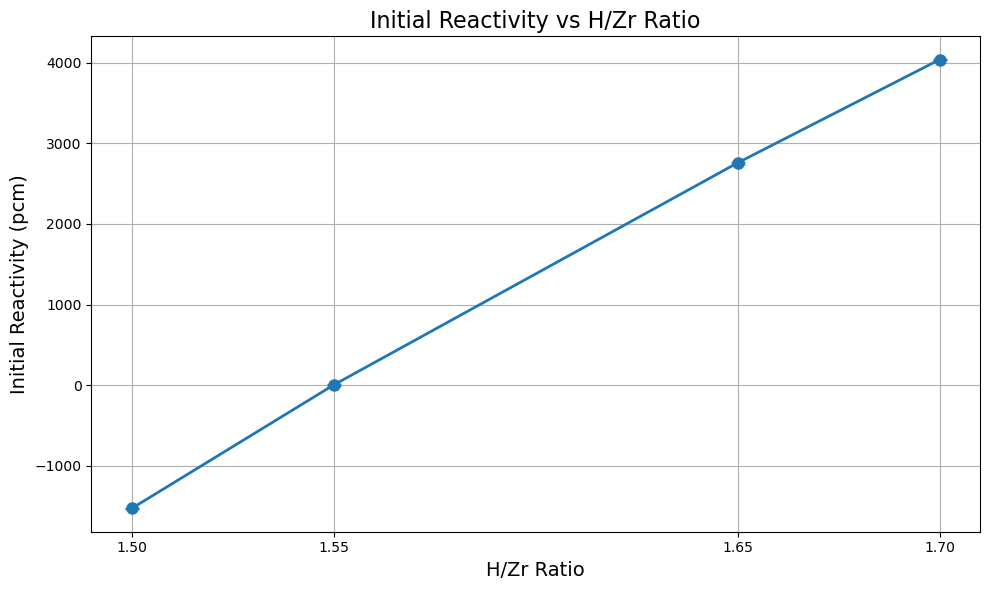

In [96]:
current_dir = Path.cwd()
ratios = ["1.5", "1.55", "1.65", "1.7"]
ratio_values = []
rho_values = []
rho_err_values = []

for ratio in ratios:
    h_zr_dir = f"H_Zr_{ratio}"
    res_rel_path = Path(f"Serpent/depletion/hydrogen_dissociation/{h_zr_dir}/s82d_ac_c3_gcu_ringres.main_res.m")
    res_path = (current_dir/res_rel_path).resolve()
    
    dep = st.read(res_path)
    # Get k values
    anakeff = dep['impKeff'][0]
    k_err = dep['impKeff'][1]
    
    # Calculate reactivity
    rho = (1 - 1/anakeff) * 10**5  # Convert to pcm
    rho_err = (k_err / anakeff**2) * 10**5  # Convert to pcm
    
    # Store values in arrays
    ratio_values.append(float(ratio))
    rho_values.append(rho)
    rho_err_values.append(rho_err)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(ratio_values, rho_values, yerr=rho_err_values, 
             fmt='o-', capsize=5, linewidth=2, markersize=8)

plt.xlabel('H/Zr Ratio', fontsize=14)
plt.ylabel('Initial Reactivity (pcm)', fontsize=14)
plt.title('Initial Reactivity vs H/Zr Ratio', fontsize=16)
plt.grid(True)
plt.xticks(ratio_values)
plt.tight_layout()
plt.show()

## Simple Hydrogen Migration

A sensitivity study was done by investigating the effect of hydrogen migration, distinct to hydrogen *loss*. While hydrogen loss was approximated earlier via uniform decrease in H/Zr atom ratio, hydrogen migration is likely to have some reactivity upswing as the fuel becomes more heterogenous thus increasing the resonance escape probablity. To check for this, the fuel was radially separated into two zones that were equal in area, with the inner portion and outer portion having different H/Zr atom ratios at 1.6 and 1.8, respectively. The reactivity increase at BOL was found to be 158 ± 15.9 pcm, indicating that the hydrogen migration effect on reactivity is not monotonically decreasing nor linear, as there will be an initial increase in reactivity that cannot be accounted for from poison burnout. Thus, while BOL and EOL excess reactivities can be well captured through improved reflector modeling and simplifications to the hydrogen migration reactivity effect as demonstrated, further investigation is needed to perfectly match the behavior of the depletion curve. While outside the scope of this work, future work could utilize this benchmark model upon completion and develop a separate benchmark for hydrogen migration modeling and its effects on reactivity.

![Alt text](/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/hydrogen_diffusion/s82d_ac_c3_gcu_ringres.main_geom1.png)

In [97]:
# Define the file paths
current_dir = Path.cwd()
res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
# Read the Serpent output files
diffusion_res = st.read((current_dir/'Serpent/reactivity_worths/hydrogen_diffusion'/res_name).resolve())
standard_res = st.read((current_dir/'Serpent/standard_reference_sol'/res_name).resolve())

# Extract k_eff values and uncertainties
diff_k = diffusion_res['anaKeff'][0]
diff_k_unc = diffusion_res['anaKeff'][1]

stand_k = standard_res['anaKeff'][0]
stand_k_unc = standard_res['anaKeff'][1]

# Convert to reactivity in units of k/k (ρ = (k-1)/k)
diff_rho = (diff_k - 1)/diff_k
stand_rho = (stand_k - 1)/stand_k

# Calculate uncertainties in reactivity
# Using error propagation: σ_ρ = √[(∂ρ/∂k)² * σ_k²]
# Where ∂ρ/∂k = 1/k²
diff_rho_unc = np.sqrt((1/diff_k**2)**2 * diff_k_unc**2)
stand_rho_unc = np.sqrt((1/stand_k**2)**2 * stand_k_unc**2)

# Convert reactivity to pcm (1 pcm = 10^-5)
diff_rho_pcm = diff_rho * 1e5
stand_rho_pcm = stand_rho * 1e5
diff_rho_unc_pcm = diff_rho_unc * 1e5
stand_rho_unc_pcm = stand_rho_unc * 1e5

# Calculate the difference in reactivity (reactivity worth)
reactivity_worth = diff_rho_pcm - stand_rho_pcm
reactivity_worth_unc = np.sqrt(diff_rho_unc**2 + stand_rho_unc**2) * 1e5

# Print results
print(f"Reactivity Worth (Diffusion - Standard) = {reactivity_worth:.2f} ± {reactivity_worth_unc:.2f} pcm")


SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/hydrogen_diffusion/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/standard_reference_sol/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.


Reactivity Worth (Diffusion - Standard) = 157.87 ± 15.96 pcm


# Depletion Comparison

Based on the hydrogen studies done earlier, the reactivity loss due to hydrogen migration reported in experiment was linearized as a functino of burnup. Experiment reports a total reactivity loss of $6.86, or 5280 pcm. The reactivity loss is then

$\begin{align}
\rho_H = -162 * b
\end{align}$

Where $\rho_H$ is reactivity worth due to hydrogen migration in pcm and $b$ is burnup in MWd/kg. The serpent benchmark model was then depleted at standard conditions ($T_c = 922K, T_f = 934K, T_{ref} = 866 K$). As the BOL reactivity of the benchmark model does not match experiment, reactivity was uniformly added to match BOL reactivity with experiment. Then, the negative reactivity worth of hydrogen was applied to the data where it was found to have good agreement with EOL reactivity.  

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/Serpent_Res/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.


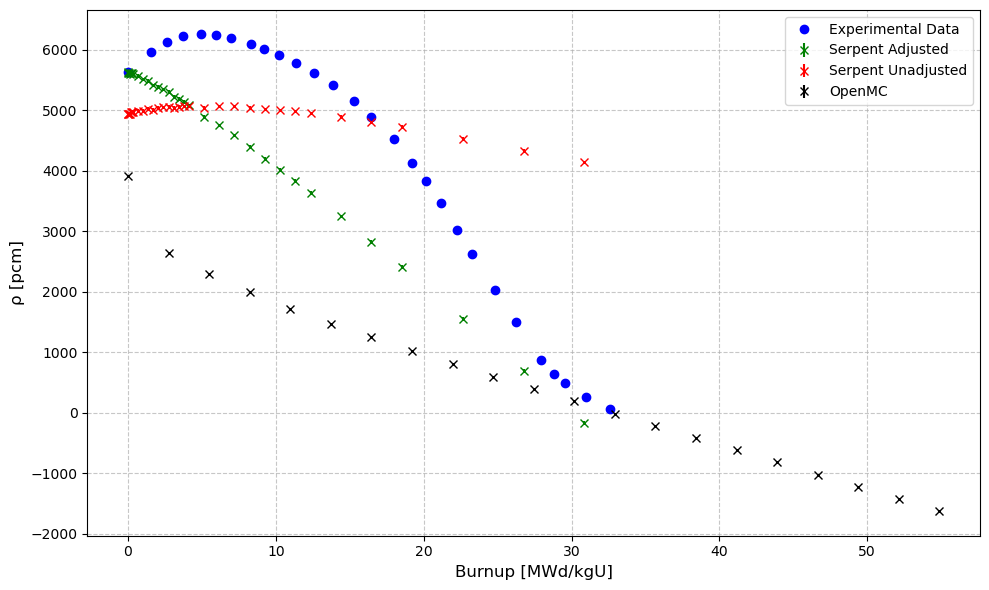

In [98]:
# Set up file paths
current_dir = Path.cwd()
base_path = current_dir / "Serpent/depletion"

# Load OpenMC results
openmc_path = base_path / "OpenMC_Res/depletion_results.h5"
openmc_burnup, openmc_rho, openmc_err = load_openmc_results(openmc_path)

# Load Serpent results
serpent_res_path = base_path / "Serpent_Res/s82d_ac_c3_gcu_ringres.main_res.m"
serpent_dep_path = base_path / "Serpent_Res/s82d_ac_c3_gcu_ringres.main_dep.m"
serpent_burnup, serpent_rho, serpent_err = load_serpent_results(serpent_res_path, serpent_dep_path)

# Apply hydrogen loss adjustment to Serpent data
serpent_rho_adjusted = adjust_for_hydrogen_loss(serpent_rho, serpent_burnup)

# Load experimental data
exp_path = base_path / "Serpent_Res/burn-data.csv"
exp_data = pd.read_csv(exp_path)
exp_burnup = exp_data['x (MWd/kgU)'].values
exp_rho = exp_data['y(pcm)'].values

# Create comparison plot
plt.figure(figsize=(10, 6))

# Plot data (exclude last 3 points for Serpent data)
plt.errorbar(exp_burnup, exp_rho, fmt='o', label="Experimental Data", color='blue')
plt.errorbar(serpent_burnup[:-3], serpent_rho_adjusted[:-3], yerr=serpent_err[:-3], 
             fmt='x', label='Serpent Adjusted', color='green')
plt.errorbar(serpent_burnup[:-3], serpent_rho[:-3], yerr=serpent_err[:-3], 
             fmt='x', label='Serpent Unadjusted', color='red')
plt.errorbar(openmc_burnup, openmc_rho, yerr=openmc_err, 
             fmt='x', label='OpenMC', color='black')

# Format plot
plt.xlabel("Burnup [MWd/kgU]", fontsize=12)
plt.ylabel("ρ [pcm]", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Reactivity Coefficients

## Fuel Temperature Coefficient

Fuel temperature coefficients were computed for the S8ER wet experiments. While specific effects were not listed in experiment, the model considered fuel doppler, grid_expansion, and thermal expansion. Poison doppler contributions were also considered though found to be insignificant. When considering the fuel element expansion, it is unclear whether it would be better suited for the fuel to expand radially, axially, or both. Wet experiment references are not clear in noting at what point of operation these temperature coefficients were taken. For this reason, it is assumed that measurements were taken near or at BOL, with thermal expansion limited axially as observed in fast spectrum liquid metal reactor analysis.Axial thermal expansion of the fuel is computed using the linear thermal expansion coefficient of U-ZrH1.6 with 8-12 wt% uranium as a function of temperature in Celsius, as reported via the MARVEL Fuel Reactor Performance Report. The linear thermal expansion coefficient is 

$\begin{align}
\alpha_{L,U-ZrH_{1.6}} = 4.52E-6 + T_c * 1.925E-8
\end{align}$

Where $T_c$ is the temperature of the fuel in celsius. Similarly, the grid expansion of the upper and lower grid plates is computed using the linear thermal expansion of the upper grid plate material, Hastelloy-N. In a realistic setting, the upper and lower grid plates would expand differently as both the temperatures at the inlet and outlet would be different along with being composed of different materials. However, as a first-order approximation the material and expansion of both plates are assumed to be the same with the main focus being on the increase in pitch between the fuel elements. The mean coefficient of thermal expansion at appropriate temperature ranges are used and are taken from Haynes International. As the material is assumed to be isotropic, the pitch will expand at the same rate as the rest of the material.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/721/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/816/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/fail

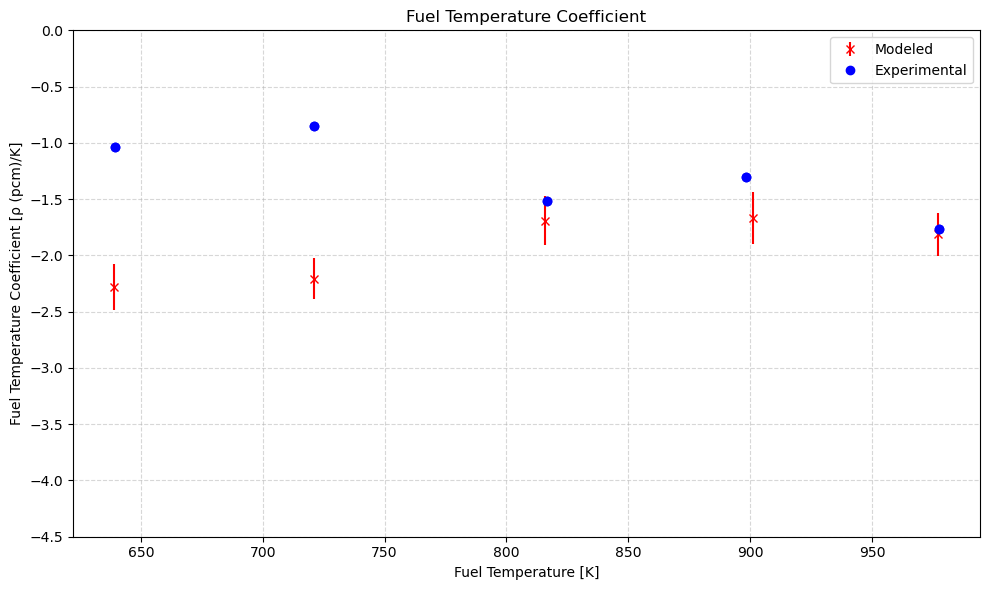

In [99]:
# Set up file paths
current_dir = Path.cwd()
base_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/ftc_effect"
res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
temp_name = ['639', '721','816','899','901','977','1070']
temp_list = [639, 721, 816, 899, 901, 977, 1070]
rho_list = []
unc_list = []
reac_list = []
reac_unc_list = []
for i in temp_name:
    res_path = Path((base_path/i/res_name).resolve())
    res = st.read(res_path)
    k = res['anaKeff'][0]
    k_unc = res['anaKeff'][1]
    rho = (k - 1)/k
    err_rho =  np.sqrt((1/k**2)**2 * k_unc**2)
    rho_list.append(rho)
    unc_list.append(err_rho * 3)

for i,temp in enumerate(temp_list):
    if temp != 1070 and temp != 899:
        reac = ((rho_list[i] - rho_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        unc = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_list[i+1]**2)*10**5
        reac_list.append(reac)
        reac_unc_list.append(unc * 1)
    else:
        pass

exp_data = pd.read_csv((base_path/'plot-data.csv').resolve())
x_data = exp_data['x(kelvin)'].values
y_data = exp_data['y(pcm/K)'].values
temp_list = [639, 721, 816, 901, 977]


plt.figure(figsize=(10, 6))
plt.title("Fuel Temperature Coefficient")
plt.xlabel('Fuel Temperature [K]')
plt.ylabel('Fuel Temperature Coefficient [ρ (pcm)/K]')

plt.errorbar(temp_list[:], reac_list[:], yerr=reac_unc_list[:], fmt='x', label="Modeled", color='red')
plt.errorbar(x_data, y_data, yerr = None, fmt = 'o', label = 'Experimental', color = 'blue')


plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(-4.5,0)
plt.tight_layout()

## Isothermal Temperature Coefficient

Isothermal temperature coefficients were computed for the S8ER. While specific phenomena were not listed as being observed with the evaluation of isothermal temperature coefficients, the serpent benchmark model asssumes fuel doppler, axial fuel element expansion, radial grid plate expansion, and coolant expansion. NaK thermophysical properties were evaluated at each temperature point and adjusted based on the Sodium-NaK Engineering Handbook Vol. 1.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/itc_effect/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/itc_effect/721/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/itc_effect/816/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/fail

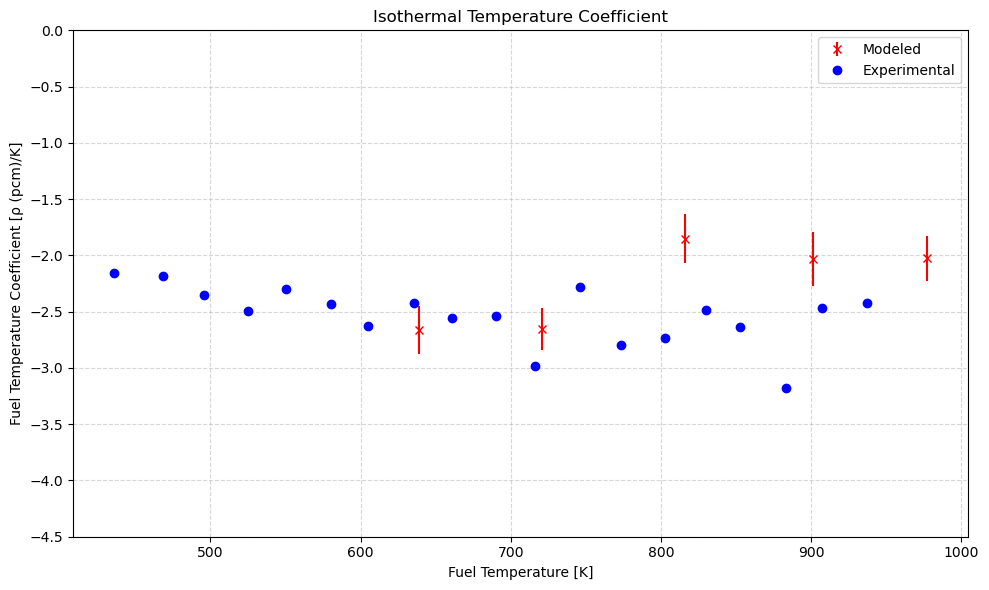

In [100]:
# Set up file paths
current_dir = Path.cwd()
base_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/itc_effect"
res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
temp_name = ['639', '721','816','899','901','977','1070']
temp_list = [639, 721, 816, 899, 901, 977, 1070]
rho_list = []
unc_list = []
reac_list = []
reac_unc_list = []

# Loop through each temperature case to extract k-effective and calculate reactivity
for i in temp_name:
    res_path = Path((base_path/i/res_name).resolve())
    res = st.read(res_path)
    k = res['anaKeff'][0]
    k_unc = res['anaKeff'][1]
    rho = (k - 1)/k
    err_rho =  np.sqrt((1/k**2)**2 * k_unc**2)
    rho_list.append(rho)
    unc_list.append(err_rho * 3)

# ignore 1070 and 899, 1070 is not in experiment and the difference between 899 and 901 gives problems
for i,temp in enumerate(temp_list):
    if temp != 1070 and temp != 899:
        reac = ((rho_list[i] - rho_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        unc = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_list[i+1]**2)*10**5
        reac_list.append(reac)
        reac_unc_list.append(unc * 1)
    else:
        pass
# read experimental data
exp_data = pd.read_csv((base_path/'itc_data.csv').resolve())
x_data = exp_data['x(kelvin)'].values
y_data = exp_data['y(pcm/K)'].values
temp_list = [639, 721, 816, 901, 977]


plt.figure(figsize=(10, 6))
plt.title("Isothermal Temperature Coefficient")
plt.xlabel('Fuel Temperature [K]')
plt.ylabel('Fuel Temperature Coefficient [ρ (pcm)/K]')

# Plot analytical data
plt.errorbar(temp_list, reac_list, yerr=reac_unc_list, fmt='x', label="Modeled", color='red')
plt.errorbar(x_data, y_data, yerr = None, fmt = 'o', label = 'Experimental', color = 'blue')


plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(-4.5,0)
plt.tight_layout()

## Power Coefficient

### Method A

In Method A, experiment computed the power coefficient as:
$\begin{align}
\frac{\Delta \rho}{\Delta P}\vert_A &= \frac{\alpha_f}{UA}\\
UA(T) &= -3e-10 *T^4 + 9e-7 * T^3 - 0.001 * T^2 + 0.5402 * T - 99.739
\end{align}$
Where the polynomial for the overall fuel to coolant heat transfer coefficient, UA, was fitted directly from experimental results.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/721/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/816/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/fail

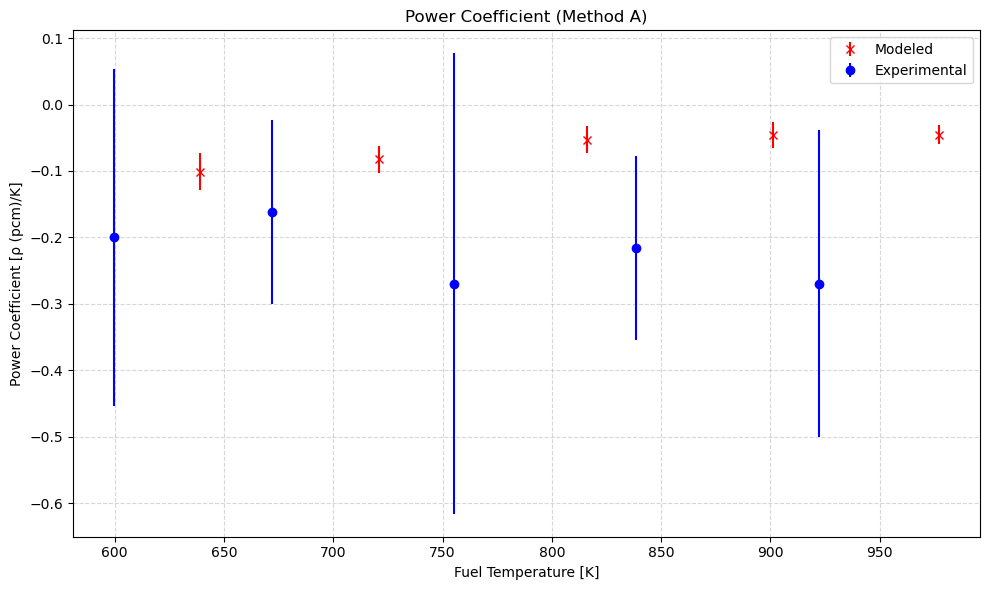

In [101]:
# Set up file paths
current_dir = Path.cwd()
base_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/ftc_effect"
res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
temp_name = ['639', '721','816','899','901','977','1070']
temp_list = [639, 721, 816, 899, 901, 977, 1070]
fuel_temp_list = [651.2536, 733.2536, 828.2536, 0,913.2536, 989.2536, 0]
rho_list = []
unc_list = []
reac_list = []
reac_unc_list = []
for i in temp_name:
    res_path = Path((base_path/i/res_name).resolve())
    res = st.read(res_path)
    k = res['anaKeff'][0]
    k_unc = res['anaKeff'][1]
    rho = (k - 1)/k
    err_rho =  np.sqrt((1/k**2)**2 * k_unc**2)
    rho_list.append(rho)
    unc_list.append(err_rho * 3)

for i,temp in enumerate(temp_list):
    if temp != 1070 and temp != 899:
        reac = ((rho_list[i] - rho_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        dP, UA = power_change(temp_list[i], fuel_temp_list[i])
        pow_coeff = reac/UA
        unc = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_list[i+1]**2)*10**5
        unc_pow_coeff = unc/UA
        reac_list.append(pow_coeff)
        reac_unc_list.append(unc_pow_coeff * 3)
    else:
        pass

pow_dir = Path("Serpent/reactivity_worths/power_coeff")
exp_data = pd.read_csv((current_dir/pow_dir/'pow_coeff_A.csv').resolve())
x_data = exp_data['x(K)'].values
y_data = exp_data['y(pcm/kW)'].values
exp_unc = 3*exp_data['unc'].values
temp_list = [639, 721, 816, 901, 977]
plt.figure(figsize=(10, 6))
plt.title("Power Coefficient (Method A)")
plt.xlabel('Fuel Temperature [K]')
plt.ylabel('Power Coefficient [ρ (pcm)/K]')

# Plot analytical data
plt.errorbar(temp_list[:], reac_list[:], yerr=reac_unc_list[:], fmt='x', label="Modeled", color='red')
plt.errorbar(x_data, y_data, yerr = exp_unc, fmt = 'o', label = 'Experimental', color = 'blue')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

### Method B

In Method B, experiment incorporated the effects of the upper plenum reactivity effect which was effectively the isolated effect of the upper grid plate expansion. To capture this effect this included the computation of the coolant flow heat capacity which are shown below:
$\begin{align}
\frac{\Delta \rho}{\Delta P}\vert_A &= \frac{\alpha_f}{UA} + \frac{1}{WC_p}\left(0.41\alpha_f + \alpha_{up}\right)\\
WC_p &= UA\frac{T_f - T_c}{T_o - T_i}
\end{align}$
Where $\alpha_{up}$ is the upper plenum reactivity coefficient, $T_f$ is the average fuel temperature, $T_c$ is the average coolant temperature, $T_o$ is the outlet coolant temperature, and $T_i$ is the average inlet coolant temperature. As an approximation, the total grid expansion coefficient (upper and lower) was computed and divided in half to ascribe half the reactivity effect to the upper and lower grid expansion. 
$\begin{align}
\frac{\Delta \rho}{\Delta P}\vert_A &= \frac{\alpha_f}{UA} + \frac{1}{WC_p}\left(0.41\alpha_f + \frac{\alpha_{ge}}{2}\right)\\
\end{align}$
Where $\alpha_{ge}$ is the cumulative effect of the upper and lower grid expansion. Fuel and coolant temperatures were computed using steady state MOOSE-based subchannel and heat transfer module calculations, where a uniform power distribution at 450 kWth was held and inlet coolant temperatures were assumed to be equivalent to nominal conditions at 866K.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/grid_expansion/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/721/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/

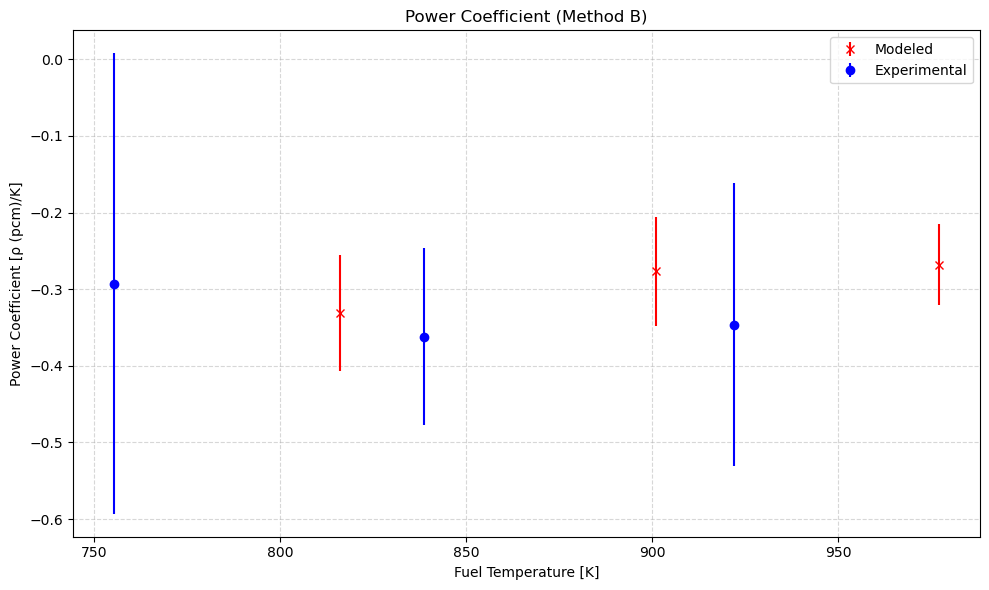

In [102]:
current_dir = Path.cwd()
ftc_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/ftc_effect"
grid_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/grid_expansion"

res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
temp_name = ['639', '721','816', '899','901','977', '1070']
temp_list = [639, 721, 816, 899, 901, 977, 1070]
fuel_temp_list = [651.2536, 733.2536, 828.2536, 0,913.2536, 989.2536, 0]
rho_ftc_list = []
unc_ftc_list = []
rho_grid_list = []
unc_grid_list = []
reac_list = []
reac_unc_list = []
for i in temp_name:
    res_path = Path((ftc_path/i/res_name).resolve())
    res_ftc = st.read(res_path)
    k_ftc = res_ftc['anaKeff'][0]
    k_ftc_unc = res_ftc['anaKeff'][1]
    rho_ftc = (k_ftc - 1)/k_ftc
    err_ftc_rho =  np.sqrt((1/k_ftc**2)**2 * k_ftc_unc**2)
    rho_ftc_list.append(rho_ftc)
    unc_ftc_list.append(err_ftc_rho)

    res_path = Path((grid_path/i/res_name).resolve())
    res_grid = st.read(res_path)
    k_grid = res_grid['anaKeff'][0]
    k_grid_unc = res_grid['anaKeff'][1]
    rho_grid = (k_grid - 1)/k_grid
    err_grid_rho =  np.sqrt((1/k_grid**2)**2 * k_grid_unc**2)
    rho_grid_list.append(rho_grid)
    unc_grid_list.append(err_grid_rho)
    

for i,temp in enumerate(temp_list):
    if temp != 1070 and temp != 899:
        reac_ftc = ((rho_ftc_list[i] - rho_ftc_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        reac_grid = ((rho_grid_list[i] - rho_grid_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        dP, UA = power_change(temp_list[i], fuel_temp_list[i])
        WC = coolant_flow_heat_capacity(temp_list[i], fuel_temp_list[i])
        pow_coeff = reac_ftc/UA + (0.41*reac_ftc+reac_grid/2)/WC
        unc_ftc = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_ftc_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_ftc_list[i+1]**2)*10**5
        unc_grid = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_grid_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_grid_list[i+1]**2)*10**5
        unc_pow_coeff = np.sqrt((1/UA+1/WC)**2 *unc_ftc**2 + (1/(2*WC))**2 * unc_grid**2)
        reac_list.append(pow_coeff)
        reac_unc_list.append(unc_pow_coeff * 3)
    else:
        pass

pow_dir = Path("Serpent/reactivity_worths/power_coeff")
exp_data = pd.read_csv((current_dir/pow_dir/'pow_coeff_B.csv').resolve())
x_data = exp_data['x(K)'].values
y_data = exp_data['y(pcm/kW)'].values
exp_unc = 3*exp_data['unc'].values
temp_list = [639, 721, 816, 901, 977]
plt.figure(figsize=(10, 6))
plt.title("Power Coefficient (Method B)")
plt.xlabel('Fuel Temperature [K]')
plt.ylabel('Power Coefficient [ρ (pcm)/K]')

# Plot analytical data
plt.errorbar(temp_list[-3:], reac_list[-3:], yerr=reac_unc_list[-3:], fmt='x', label="Modeled", color='red')
plt.errorbar(x_data[-3:], y_data[-3:], yerr = exp_unc[-3:], fmt = 'o', label = 'Experimental', color = 'blue')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pow_coeff_B.png', dpi = 400)

### Method C

In Method C, experiment incorporated the effects of the lower plenum reactivity effect, which similar to Method B is effectivley isolated to the lower grid plate expansion. The equation used in experiment is shown below
$\begin{align}
\frac{\Delta \rho}{\Delta P}\vert_A &= \frac{\alpha_f}{UA} - \frac{1}{WC_p}\left(0.41\alpha_f + \alpha_{lp}\right)\\
\frac{\Delta \rho}{\Delta P}\vert_A &= \frac{\alpha_f}{UA} - \frac{1}{WC_p}\left(0.41\alpha_f + \frac{\alpha_{ge}}{2}\right)\\
\end{align}$
Where the second equation shows the approximation used in the benchmark, where it is assumed that half of the reactivity affect to grid expansion can be ascribed to the lower and upper grid plate.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/grid_expansion/639/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/fuel_coeff/ftc_effect/721/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/

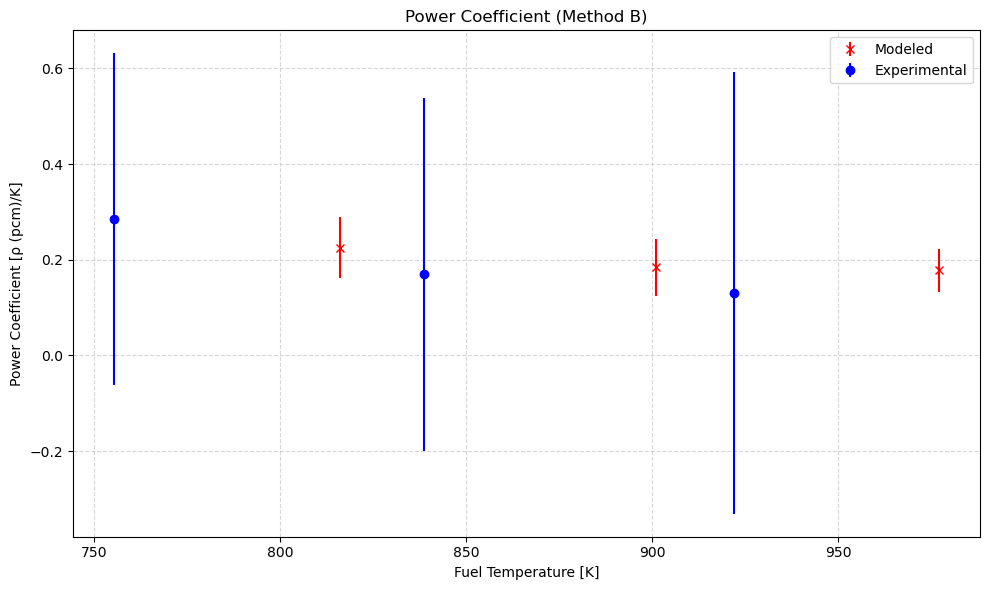

In [103]:
current_dir = Path.cwd()
ftc_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/ftc_effect"
grid_path = current_dir / "Serpent/reactivity_worths/fuel_coeff/grid_expansion"

res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
temp_name = ['639', '721','816', '899','901','977', '1070']
temp_list = [639, 721, 816, 899, 901, 977, 1070]
fuel_temp_list = [651.2536, 733.2536, 828.2536, 0,913.2536, 989.2536, 0]
rho_ftc_list = []
unc_ftc_list = []
rho_grid_list = []
unc_grid_list = []
reac_list = []
reac_unc_list = []
for i in temp_name:
    res_path = Path((ftc_path/i/res_name).resolve())
    res_ftc = st.read(res_path)
    k_ftc = res_ftc['anaKeff'][0]
    k_ftc_unc = res_ftc['anaKeff'][1]
    rho_ftc = (k_ftc - 1)/k_ftc
    err_ftc_rho =  np.sqrt((1/k_ftc**2)**2 * k_ftc_unc**2)
    rho_ftc_list.append(rho_ftc)
    unc_ftc_list.append(err_ftc_rho)

    res_path = Path((grid_path/i/res_name).resolve())
    res_grid = st.read(res_path)
    k_grid = res_grid['anaKeff'][0]
    k_grid_unc = res_grid['anaKeff'][1]
    rho_grid = (k_grid - 1)/k_grid
    err_grid_rho =  np.sqrt((1/k_grid**2)**2 * k_grid_unc**2)
    rho_grid_list.append(rho_grid)
    unc_grid_list.append(err_grid_rho)
    

for i,temp in enumerate(temp_list):
    if temp != 1070 and temp != 899:
        reac_ftc = ((rho_ftc_list[i] - rho_ftc_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        reac_grid = ((rho_grid_list[i] - rho_grid_list[i+1]) / (temp_list[i] - temp_list[i+1])) * 10**5
        dP, UA = power_change(temp_list[i], fuel_temp_list[i])
        WC = coolant_flow_heat_capacity(temp_list[i], fuel_temp_list[i])
        pow_coeff = reac_ftc/UA - (0.41*reac_ftc+reac_grid/2)/WC
        unc_ftc = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_ftc_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_ftc_list[i+1]**2)*10**5
        unc_grid = np.sqrt((1/(temp_list[i] - temp_list[i+1]))**2 * unc_grid_list[i]**2 + (1/(temp_list[i] - temp_list[i+1]))**2 * unc_grid_list[i+1]**2)*10**5
        unc_pow_coeff = np.sqrt((1/UA-1/WC)**2 *unc_ftc**2 + (1/(2*WC))**2 * unc_grid**2)
        reac_list.append(pow_coeff)
        reac_unc_list.append(unc_pow_coeff * 3)
    else:
        pass

pow_dir = Path("Serpent/reactivity_worths/power_coeff")
exp_data = pd.read_csv((current_dir/pow_dir/'pow_coeff_C.csv').resolve())
x_data = exp_data['x(K)'].values
y_data = exp_data['y(pcm/kW)'].values
exp_unc = 3*exp_data['unc'].values
temp_list = [639, 721, 816, 901, 977]
plt.figure(figsize=(10, 6))
plt.title("Power Coefficient (Method B)")
plt.xlabel('Fuel Temperature [K]')
plt.ylabel('Power Coefficient [ρ (pcm)/K]')

# Plot analytical data
plt.errorbar(temp_list[-3:], reac_list[-3:], yerr=reac_unc_list[-3:], fmt='x', label="Modeled", color='red')
plt.errorbar(x_data[-3:], y_data[-3:], yerr = exp_unc[-3:], fmt = 'o', label = 'Experimental', color = 'blue')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('pow_coeff_B.png', dpi = 400)

## Poison Worth

In experiment the Samarium poison reactivity effects were dtermined by measuring the change in excess reactivity at steady-state conditions with sufficiently low coolant temperatures to mitigate the impact of hydrogen redistribution effects. Measurement were taken at three different points in reactor lifetime at 580, 1800, and 3000 hours of operation with results normalized to a 425 kWt power output and 703.15 average coolant temperature. Corrections were made for variation in temperature, power, xenon buildup, and hydrogen redistribution effects. The total Samarium reactivity worth is the combined effect of Samarium build and prepoison burnout. In the Serpent model, the poison worth was measured by comparing BOL excess reactivities with and without the burnable poison, with xenon equilibrium toggled on. 

In [104]:
current_dir = Path.cwd()
poison_path = Path("Serpent/reactivity_worths/poison_coeff")
res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
poison_res = st.read((current_dir/poison_path/res_name).resolve())
standard_res = st.read((current_dir/'Serpent/standard_reference_sol'/res_name).resolve())

# First case (poison)
poi_k = poison_res['anaKeff'][0]
poi_k_unc = poison_res['anaKeff'][1]  # This is absolute uncertainty in k
poi_rho = (poi_k - 1)/poi_k
# Propagate absolute uncertainty to reactivity
poi_rho_unc = np.sqrt((1/poi_k**2)**2 * poi_k_unc**2)

# Standard case
stand_k = standard_res['anaKeff'][0]
stand_k_unc = standard_res['anaKeff'][1]  # This is absolute uncertainty in k
stand_rho = (stand_k - 1)/stand_k
# Propagate absolute uncertainty to reactivity
stand_rho_unc = np.sqrt((1/stand_k**2)**2 * stand_k_unc**2)

# Calculate reactivity worth in pcm
poison_worth = (poi_rho - stand_rho) * 10**5

# Propagate absolute uncertainties for the difference 
poison_worth_unc = np.sqrt(poi_rho_unc**2 + stand_rho_unc**2) * 10**5

# If a 3-sigma confidence interval is desired
poison_worth_unc_3sigma = poison_worth_unc * 3
exp_poison_worth = -1100
exp_poison_unc = 240
# Print both 1-sigma and 3-sigma results
print(f"Modeled poison worth is -{poison_worth:.2f} \u00B1 {poison_worth_unc:.2f} pcm (1σ)")
print(f"Experimental poison worth is {exp_poison_worth:.2f} \u00B1 {exp_poison_unc:.2f} pcm (1σ)")

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/poison_coeff/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/standard_reference_sol/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.


Modeled poison worth is -1781.32 ± 15.72 pcm (1σ)
Experimental poison worth is -1100.00 ± 240.00 pcm (1σ)


## Coolant Worth

Coolant reactivity effect in experiment is measured as the difference between excess reactivity between the dry experiment with no coolant and the BOL excess reactivity with coolant. Though there is no mention of the shim configuration used as the total excess reactivity used for the dry experiment it is implied to be an A-B configuration. It would stand to reason, then, that the wet experiment reflector configuration should similarly follow an A-B shim configuration though images would suggest the implementation of a third shim. Thus, to measure the NaK reactivity worth in serpent the BOL excess reactivity with xenon equilibrium toggled in is compared for cores with and without NaK present.

In [105]:
current_dir = Path.cwd()
poison_path = Path("Serpent/reactivity_worths/NaK_worth")
res_name = 's82d_ac_c3_gcu_ringres.main_res.m'
poison_res = st.read((current_dir/poison_path/res_name).resolve())
standard_res = st.read((current_dir/'Serpent/standard_reference_sol'/res_name).resolve())

# First case (poison)
no_nak_k = poison_res['anaKeff'][0]
no_nak_k_unc = poison_res['anaKeff'][1]  # This is absolute uncertainty in k
no_nak_rho = (no_nak_k - 1)/no_nak_k
# Propagate absolute uncertainty to reactivity
no_nak_rho_unc = np.sqrt((1/no_nak_k**2)**2 * no_nak_k_unc**2)

# Standard case
stand_k = standard_res['anaKeff'][0]
stand_k_unc = standard_res['anaKeff'][1]  # This is absolute uncertainty in k
stand_rho = (stand_k - 1)/stand_k
# Propagate absolute uncertainty to reactivity
stand_rho_unc = np.sqrt((1/stand_k**2)**2 * stand_k_unc**2)

# Calculate reactivity worth in pcm
nak_worth = (no_nak_rho - stand_rho) * 1e5

# Propagate absolute uncertainties for the difference 
nak_worth_unc = np.sqrt(no_nak_rho_unc**2 + stand_rho_unc**2) * 1e5

# If a 3-sigma confidence interval is desired
nak_worth_unc_3sigma = nak_worth_unc * 3
exp_nak_worth = -310
exp_nak_unc = 20
# Print both 1-sigma and 3-sigma results
print(f"NaK worth is -{nak_worth:.2f} \u00B1 {nak_worth_unc:.2f} pcm (1σ)")
print(f"NaK worth is {exp_nak_worth:.2f} \u00B1 {exp_nak_unc:.2f} pcm (1σ)")

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/NaK_worth/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/standard_reference_sol/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.


NaK worth is -72.23 ± 16.60 pcm (1σ)
NaK worth is -310.00 ± 20.00 pcm (1σ)


## Xenon Worth

Xenon equilibrium worth was determined in experiment via monitoring change in excess reactivity caused by rapid changes in steady-state power levels. These changes were made in combinations that minimized other transient reactivity effects caused by hydrogen redistribution, power, and temperature changes. The excess reactivity in experiment was corrected to account for reactivity effects that could not be eliminated by experimental technique, though no outlining of these corrections is provided. In Serpent, reactivity differences were computed between BOL core with xenon equilibrium and without xenon equilibrium at different core powers.

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/xenon_worth/100kw/xenon/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/xenon_worth/100kw/no_xenon/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/reactivity_worths/xenon_worth/200kw/xenon/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failure

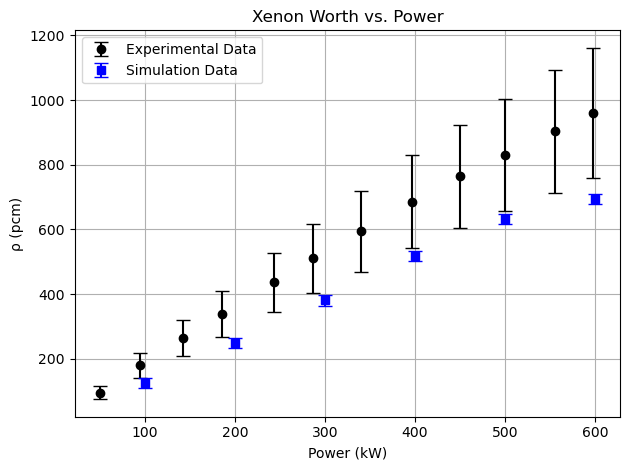

In [106]:
# --- Load CSV data ---
xenon_path = current_dir / "Serpent/reactivity_worths/xenon_worth"
csv_path = Path(xenon_path / 'exp_data.csv')  # Replace with actual file name
csv_df = pd.read_csv(csv_path)
x_csv = csv_df['x(power[kw])']
y_csv = csv_df['y(pcm)']
unc_csv = 3*csv_df['unc(pcm)']

# --- Prepare simulation data ---
power_levels = [f"{i}kw" for i in range(100, 601, 100)]
reactivity_diffs = []
reactivity_uncs = []

res_name = 's82d_ac_c3_gcu_ringres.main_res.m'

for power in power_levels:
    base_dir = xenon_path / power
    xenon_file = base_dir / 'xenon' / res_name
    no_xenon_file = base_dir / 'no_xenon' / res_name


    # Read xenon case
    xenon_res = st.read(xenon_file)
    k_xenon = xenon_res['anaKeff'][0]
    k_xenon_unc = xenon_res['anaKeff'][1]
    rho_xenon = (k_xenon - 1) / k_xenon
    rho_xenon_unc = np.abs((1 / k_xenon**2)) * k_xenon_unc

    # Read no_xenon case
    nox_res = st.read(no_xenon_file)
    k_nox = nox_res['anaKeff'][0]
    k_nox_unc = nox_res['anaKeff'][1]
    rho_nox = (k_nox - 1) / k_nox
    rho_nox_unc = np.abs((1 / k_nox**2)) * k_nox_unc

    # Calculate worth and uncertainty in pcm
    worth_pcm = (rho_nox - rho_xenon) * 1e5
    worth_unc_pcm = np.sqrt(rho_xenon_unc**2 + rho_nox_unc**2) * 1e5

    reactivity_diffs.append(worth_pcm)
    reactivity_uncs.append(worth_unc_pcm)

# X-values for simulation plot
x_sim = [int(p.strip('kw')) for p in power_levels[:len(reactivity_diffs)]]

# --- Plotting ---
plt.errorbar(x_csv, y_csv, yerr=unc_csv, fmt='o', label='Experimental Data', capsize=5, color='black')
plt.errorbar(x_sim, reactivity_diffs, yerr=reactivity_uncs, fmt='s', label='Simulation Data', capsize=5, color='blue')

plt.xlabel('Power (kW)')
plt.ylabel('ρ (pcm)')
plt.title('Xenon Worth vs. Power')
plt.grid(True)
plt.legend()
plt.tight_layout()